In [1]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.types import StructType

import findspark
findspark.init()
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark.sql.functions as sql_fun

In [ ]:
# spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests, zipfile, io
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
covid_df = spark.read.parquet("gs://msca-bdp-test-1203/covid_tweets4_df.parquet/")

22/03/20 00:16:55 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
covid_df.count()

17354708

In [14]:
time_df = covid_df.groupby('created_at_year','created_at_mon','created_at_day','retweeted') \
                    .agg(count(covid_df.id).alias('t_count')) \
                    .sort('created_at_year','created_at_mon','created_at_day','retweeted')

In [ ]:
time_df.show()

+---------------+--------------+--------------+---------+-------+
|created_at_year|created_at_mon|created_at_day|retweeted|t_count|
+---------------+--------------+--------------+---------+-------+
|           2021|            10|            15|    false| 113629|
|           2021|            10|            15|     true| 262604|
|           2021|            10|            16|    false|  95171|
|           2021|            10|            16|     true| 242367|
|           2021|            10|            17|    false|  92013|
|           2021|            10|            17|     true| 239624|
|           2021|            10|            18|    false| 155042|
|           2021|            10|            18|     true| 410134|
|           2021|            10|            19|    false| 138957|
|           2021|            10|            19|     true| 354075|
|           2021|            10|            20|    false| 146193|
|           2021|            10|            20|     true| 361699|
|         

In [17]:
time_df.toPandas().to_csv('gs://msca-bdp-test-1203/time_df.csv')

In [44]:
full_time_pdf = pd.read_csv('gs://msca-bdp-test-1203/full_time_df.csv')
full_time_pdf.head()

,Unnamed: 0,created_at_year,created_at_mon,created_at_day,retweeted,t_count
0,0,2021,10,15,False,29619
1,1,2021,10,15,True,51807
2,2,2021,10,16,False,27207
3,3,2021,10,16,True,46579
4,4,2021,10,17,False,26587


In [45]:
full_time_pdf['dateInt']=full_time_pdf['created_at_year'].astype(str) + full_time_pdf['created_at_mon'].astype(str).str.zfill(2)+ full_time_pdf['created_at_day'].astype(str).str.zfill(2)
full_time_pdf['Date'] = pd.to_datetime(full_time_pdf['dateInt'], format='%Y%m%d')

In [46]:
full_time_pdf

,Unnamed: 0,created_at_year,created_at_mon,created_at_day,retweeted,t_count,dateInt,Date
0,0,2021,10,15,False,29619,20211015,2021-10-15
1,1,2021,10,15,True,51807,20211015,2021-10-15
2,2,2021,10,16,False,27207,20211016,2021-10-16
3,3,2021,10,16,True,46579,20211016,2021-10-16
4,4,2021,10,17,False,26587,20211017,2021-10-17
...,...,...,...,...,...,...,...,...
201,201,2022,1,23,True,69137,20220123,2022-01-23
202,202,2022,1,24,False,52034,20220124,2022-01-24
203,203,2022,1,24,True,77800,20220124,2022-01-24
204,204,2022,1,25,False,35959,20220125,2022-01-25


In [47]:
full_time_pdf.drop(['Unnamed: 0','dateInt','created_at_day','created_at_mon','created_at_year'],axis='columns',inplace=True)
# full_time_pdf.set_index(['Date'], inplace=True)

In [36]:
# full_time_pdf = full_time_pdf.pivot(columns='retweeted', values='t_count')

In [48]:
full_time_pdf

,retweeted,t_count,Date
0,False,29619,2021-10-15
1,True,51807,2021-10-15
2,False,27207,2021-10-16
3,True,46579,2021-10-16
4,False,26587,2021-10-17
...,...,...,...
201,True,69137,2022-01-23
202,False,52034,2022-01-24
203,True,77800,2022-01-24
204,False,35959,2022-01-25


In [42]:
full_time_pdf.columns

Index([False, True], dtype='object', name='retweeted')

<AxesSubplot:title={'center':'Tweet and Retweet Timeline'}, xlabel='Date', ylabel='Number of Tweets /Retweets'>

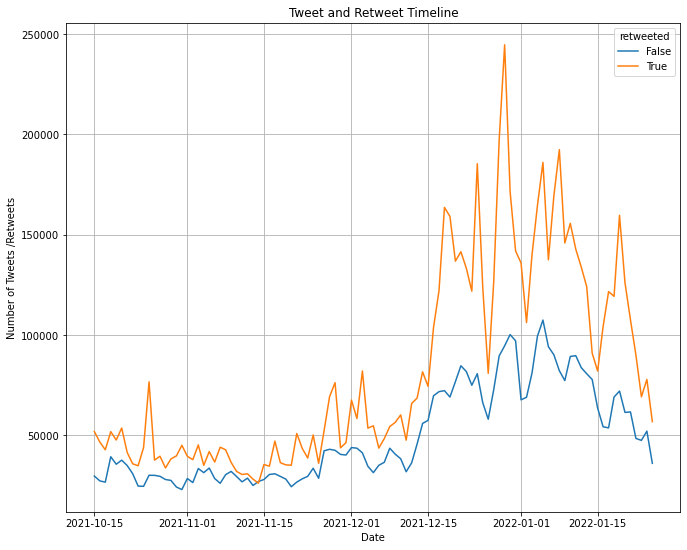

In [53]:
import seaborn as sns
f, ax = plt.subplots(figsize=(11, 9))

plt.title('Tweet and Retweet Timeline')
plt.ylabel('Number of Tweets /Retweets')
plt.grid(True)

sns.lineplot(data=full_time_pdf, x='Date', y='t_count', hue='retweeted')

In [25]:
full_time_pdf.sort_values(['retweeted','created_at_year','created_at_mon','created_at_day'],inplace=True)

In [21]:
full_time_pdf.set_index(['created_at_year','created_at_mon','created_at_day'], inplace=True)

In [26]:
full_time_pdf.drop('Unnamed: 0',axis='columns',inplace=True)

In [27]:
full_time_pdf = full_time_pdf.pivot(columns='retweeted', values='t_count')

In [28]:
full_time_pdf

retweeted,False,True
0,29619.0,NaN
1,NaN,51807.0
2,27207.0,NaN
3,NaN,46579.0
4,26587.0,NaN
...,...,...
201,NaN,69137.0
202,52034.0,NaN
203,NaN,77800.0
204,35959.0,NaN


In [16]:
full_time_pdf = pd.read_csv('gs://msca-bdp-test-1203/full_time_df.csv')

In [17]:
full_time_pdf.drop('Unnamed: 0',axis='columns',inplace=True)

In [ ]:
full_time_pdf = full_time_pdf.pivot(index=['x'], columns='retweeted', values='t_count')

ValueError: Invalid color False

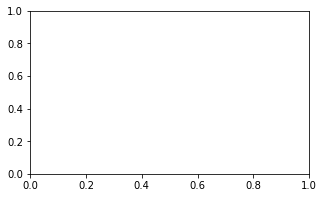

In [18]:
full_time_pdf.plot(color=full_time_pdf.retweeted, figsize=(5, 3))